## Project Demo
Here we provide a brief, runnable example of some of the components we've been working on.

### S5 Forecaster Demo (Jan)
The S5 model (https://arxiv.org/abs/2208.04933) is a relatively new network architecture that is strongly grounded in control theory. As a result, we think it could be particularly amenable to use in data-driven control. Here, we demonstrate the training of an S5 model to forecast a simple sine wave.

In [1]:
import torch
import RNNmpc
import matplotlib.pyplot as plt

# NOTE: the time series dtype must be torch.complex128 as the model requires complex values!
t_range = torch.arange(0, 10*torch.pi, step=0.01).to(torch.complex128)
sine_wave = torch.sin(t_range).reshape(1,-1) # correct training data shape

# instantiate model params
n_in = 1
n_hidden = 32
num_layers = 6
fcast_steps = 2
delta = 0.01
params = (n_in, n_hidden, num_layers, fcast_steps, delta)

# instantiate model
s5_model = RNNmpc.Forecasters.s5_forecaster.S5Forecaster(params)

The next cell could take a while to run as the model trains (~10 mins on M2 Macbook Air CPU). If you're just interested in seeing the output and not correctness, you can manually decrease num_epochs.

In [2]:
num_epochs = 100
lr = 0.001 # learning rate
lags = 52 # sequence length of input used to generate forecast

RNNmpc.Forecasters.s5_forecaster.train_model(s5_model, sine_wave, lr, lags, num_epochs)

/opt/homebrew/Caskroom/miniforge/base/envs/rnn-mpc/lib/python3.10/site-packages/torch/_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


Epoch: 0
Val. Loss: 0.5180605174676184
Epoch: 1
Val. Loss: 0.10021084650712275
Epoch: 2
Val. Loss: 0.07832855577657775
Epoch: 3
Val. Loss: 0.07304762329360723
Epoch: 4
Val. Loss: 0.06059138875368677
Epoch: 5
Val. Loss: 0.03586269443836109
Epoch: 6
Val. Loss: 0.005051153900392316
Epoch: 7
Val. Loss: 0.0031406084698494545
Epoch: 8
Val. Loss: 0.0022317145048842725
Epoch: 9
Val. Loss: 0.001563284252529979
Epoch: 10
Val. Loss: 0.0010747365108144027
Epoch: 11
Val. Loss: 0.0006422706957640427
Epoch: 12
Val. Loss: 0.0004272512607162627
Epoch: 13
Val. Loss: 0.00023046113676815716
Epoch: 14
Val. Loss: 0.00017019974217521446
Epoch: 15
Val. Loss: 0.00010933742234239387
Epoch: 16
Val. Loss: 8.187261753828629e-05
Epoch: 17
Val. Loss: 5.868730872947349e-05
Epoch: 18
Val. Loss: 6.326161498512515e-05
Epoch: 19
Val. Loss: 4.055179692956497e-05
Epoch: 20
Val. Loss: 4.1795048063821026e-05
Epoch: 21
Val. Loss: 2.6658083099123653e-05
Epoch: 22
Val. Loss: 2.6007842406974388e-05
Epoch: 23
Val. Loss: 2.0849922

Now plotting the (very short) forecast compared to the ground truth for some initial condition.

Text(0, 0.5, 'sine wave')

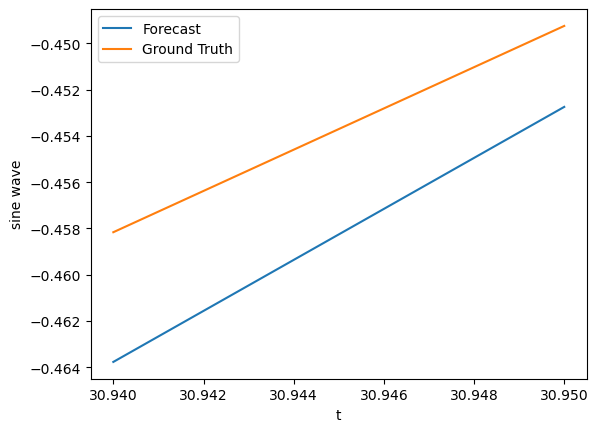

In [13]:
forecast_ic = sine_wave[:, -100:-48].T.reshape(52, 1, 1) # just some initial condition in correct shape
forecast = s5_model.forward(forecast_ic, delta=0.01).detach().numpy()
plt.plot(t_range[-48:-46].real, forecast[:,0,0], label='Forecast')
plt.plot(t_range[-48:-46].real, sine_wave[0, -48:-46].real, label='Ground Truth') # ground truth
plt.legend()
plt.xlabel("t")
plt.ylabel("sine wave")

A couple notes on the model as it is currently implemented:
1. The model is inefficient. The whole point of S5 models is that they can be efficiently parallelized. Unfortunately, PyTorch does not make this parallelization easy. As it stands, the model is too slow to be practically useful. Future directions here likely include offloading the parallelization to Jax or moving to a Jax framework altogether.

2. Due to the time constraints of the project, the model is fairly minimal and there are a variety of hard-coded options that should be decided by the user (batch size during training, for instance). More importantly, the model currently assumes that any control input is constant. This is clearly limiting and does not conform with the API of the other pre-existing models in the package. This too will be addressed in future work.